In [3]:
from functools import lru_cache
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

@lru_cache(maxsize=None)
def fetch_data_from_source(file):
    '''
    Files:
        f1sim-data-2022.parquet
        f1sim-data-2023.parquet

        f1sim-data-dictionary.xlsx

        f1sim-ref-left.csv
        f1sim-ref-line.csv
        f1sim-ref-right.csv
        f1sim-ref-turns.csv
    '''
    if file.split(".")[1] == "parquet":
        df = pd.read_parquet(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}")
    elif file.split(".")[1] == "csv":
        df = pd.read_csv(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}", index_col = 0)
    elif file.split(".")[1] == "xlsx":
        df = pd.read_excel(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}")
    return df

In [4]:
left = fetch_data_from_source('f1sim-ref-left.csv')
right = fetch_data_from_source('f1sim-ref-right.csv')
line = fetch_data_from_source('f1sim-ref-line.csv')
turns = fetch_data_from_source('f1sim-ref-turns.csv')

In [5]:
df = fetch_data_from_source('track_ratio.csv')
df["on_track"] = np.where(df["track_ratio_left"]+df["track_ratio_right"]<1.1, 1, 0)

df['agg'] = df['SESSION_IDENTIFIER'].astype(str) + '_' + df['LAP_NUM'].astype(str)

In [6]:
df = df[(df["WORLDPOSX"] < 500) & (df["WORLDPOSX"] > 200) & (df["WORLDPOSY"] < 400) & (df["WORLDPOSY"] > -100)]

In [7]:
ls = df["agg"].unique()
ls_legit = []

for elem in ls:
    new = df[df["agg"] == elem]

    entry = 0
    within = 0
    exit = 0
    off_track = 0

    for i, res in new.iterrows():
        if (200 < res["WORLDPOSX"] < 350) & (200 < res["WORLDPOSY"] < 400):
            entry += 1
        if (350 < res["WORLDPOSX"] < 400) & (100 < res["WORLDPOSY"] < 250):
            within += 1
        if (350 < res["WORLDPOSX"] < 500) & (-100 < res["WORLDPOSY"] < 100):
            exit += 1
        if res["on_track"] == 0:
            off_track += 1

    if (entry >= 1) & (within >= 1) & (exit >= 1) & (off_track == 0):
        ls_legit.append(elem)

In [8]:
df = df[df['agg'].isin(ls_legit)]

In [9]:
grouped = df.groupby(["agg"])
result = grouped["SPEED_KPH"].last()

last_time = pd.DataFrame(result)
last_time

,SPEED_KPH
agg,
1.00346768666644e+19_1,264.0
1.00346768666644e+19_2,264.0
1.0045550089308109e+19_1,257.0
1.0045550089308109e+19_2,206.0
1.0045550089308109e+19_3,262.0
...,...
9.93719767677717e+18_2,271.0
9.93719767677717e+18_3,271.0
9.943356580072892e+18_1,274.0


In [10]:
grouped = df.groupby(["agg"])
result = grouped["CURRENT_LAP_TIME_MS"].last() - grouped["CURRENT_LAP_TIME_MS"].first()

time_sector0 = pd.DataFrame(result)
time_sector0

,CURRENT_LAP_TIME_MS
agg,
1.00346768666644e+19_1,9292
1.00346768666644e+19_2,9309
1.0045550089308109e+19_1,6890
1.0045550089308109e+19_2,5764
1.0045550089308109e+19_3,8175
...,...
9.93719767677717e+18_2,8759
9.93719767677717e+18_3,8693
9.943356580072892e+18_1,8674


In [11]:
df_agg_total = pd.concat([time_sector0, last_time], axis = 1)
df_agg_total["Rank"] = -df_agg_total["CURRENT_LAP_TIME_MS"] + 40*df_agg_total["SPEED_KPH"]
df_agg_total = df_agg_total.sort_values(by='Rank', ascending=False)
df_agg_total

,CURRENT_LAP_TIME_MS,SPEED_KPH,Rank
agg,,,
9.443149153309372e+18_3,5055,245.0,4745.0
1.4054303838250777e+19_4,5864,265.0,4736.0
9.363995516070097e+18_2,5072,243.0,4648.0
4.486621736790789e+18_6,6356,273.0,4564.0
1.454581239023412e+19_2,5355,244.0,4405.0
...,...,...,...
2.6296057087567524e+18_2,15315,138.0,-9795.0
1.2869129974679448e+19_21,13781,79.0,-10621.0
2.5846237170413824e+18_1,18803,141.0,-13163.0


In [12]:
grouped = df.groupby(["agg"])
result = grouped["SPEED_KPH"].last()

last_time = pd.DataFrame(result)
last_time

grouped = df.groupby(["agg"])
result = grouped["CURRENT_LAP_TIME_MS"].last() - grouped["CURRENT_LAP_TIME_MS"].first()

time_sector0 = pd.DataFrame(result)
time_sector0

,CURRENT_LAP_TIME_MS
agg,
1.00346768666644e+19_1,9292
1.00346768666644e+19_2,9309
1.0045550089308109e+19_1,6890
1.0045550089308109e+19_2,5764
1.0045550089308109e+19_3,8175
...,...
9.93719767677717e+18_2,8759
9.93719767677717e+18_3,8693
9.943356580072892e+18_1,8674


In [13]:
grouped = df.groupby(["agg"])
result = grouped["SPEED_KPH"].last()

counts = pd.DataFrame(result)
counts

,SPEED_KPH
agg,
1.00346768666644e+19_1,264.0
1.00346768666644e+19_2,264.0
1.0045550089308109e+19_1,257.0
1.0045550089308109e+19_2,206.0
1.0045550089308109e+19_3,262.0
...,...
9.93719767677717e+18_2,271.0
9.93719767677717e+18_3,271.0
9.943356580072892e+18_1,274.0


In [14]:
value_counts = pd.value_counts(sorted(counts["SPEED_KPH"]))
value_counts

273.0    29
272.0    26
270.0    24
274.0    24
268.0    21
         ..
182.0     1
178.0     1
175.0     1
173.0     1
278.0     1
Length: 119, dtype: int64

In [15]:
df_agg_total = pd.concat([time_sector0, last_time], axis = 1)
df_agg_total

,CURRENT_LAP_TIME_MS,SPEED_KPH
agg,,
1.00346768666644e+19_1,9292,264.0
1.00346768666644e+19_2,9309,264.0
1.0045550089308109e+19_1,6890,257.0
1.0045550089308109e+19_2,5764,206.0
1.0045550089308109e+19_3,8175,262.0
...,...,...
9.93719767677717e+18_2,8759,271.0
9.93719767677717e+18_3,8693,271.0
9.943356580072892e+18_1,8674,274.0


In [16]:
# Adding new columns
df_agg_total = df_agg_total.assign(
    BEFORE_ENTRY_BRAKE_X = 0,
    BEFORE_ENTRY_BRAKE_Y = 0,
    BEFORE_ENTRY_BRAKE_GEAR = 0,
    BEFORE_ENTRY_BRAKE_STEERING = 0,
    BEFORE_ENTRY_BRAKE_SPEED = 0,
    BEFORE_ENTRY_BRAKE_RPM = 0,

    WITHIN_BRAKE_X = 0,
    WITHIN_BRAKE_Y = 0,
    WTHIN_BRAKE_GEAR = 0,
    WITHIN_BRAKE_STEERING = 0,
    WITHIN_BRAKE_SPEED = 0,
    WITHIN_BRAKE_RPM = 0,

    WITHIN_THROTTLE_X = 0,
    WITHIN_THROTTLE_Y = 0,
    WITHIN_THROTTLE_GEAR = 0,
    WITHIN_THROTTLE_STEERING = 0,
    WITHIN_THROTTLE_SPEED = 0,
    WITHIN_THROTTLE_RPM = 0,
)

In [17]:
# For each agg, we find the point of brake, the point of throttle etc

for i, elem in enumerate(df_agg_total.index):
    df_temp = df[df["agg"] == elem]

    counter_before = 0
    counter_within_brake = 0
    counter_within_throttle = 0

    for index, row in df_temp.iterrows():
        # BEFORE ENTRY
        if (200 < row["WORLDPOSX"] < 350) & (200 < row["WORLDPOSY"] < 400) and (counter_before == 0) and (row["BRAKE"] > 0.5):
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_X'] = row["WORLDPOSX"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_Y'] = row["WORLDPOSY"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_GEAR'] = row["GEAR"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_STEERING'] = row["STEERING"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_SPEED'] = row["SPEED_KPH"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_RPM'] = row["ENGINE_RPM"]
            counter_before = 1


        # WITHIN BRAKE. We expect very little braking so we find when there is a little brake.
        if (350 < row["WORLDPOSX"] < 400) & (100 < row["WORLDPOSY"] < 250) and (counter_within_brake == 0) and row["BRAKE"] > 0:
            df_agg_total.loc[elem, 'WITHIN_BRAKE_X'] = row["WORLDPOSX"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_Y'] = row["WORLDPOSY"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_GEAR'] = row["GEAR"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_STEERING'] = row["STEERING"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_SPEED'] = row["SPEED_KPH"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_RPM'] = row["ENGINE_RPM"]
            counter_within_brake = 1


        # WITHIN THROTTLE
        if (350 < row["WORLDPOSX"] < 500) & (-100 < row["WORLDPOSY"] < 100) and (counter_within_throttle == 0) and row["THROTTLE"] > 0.5:
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_X'] = row["WORLDPOSX"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_Y'] = row["WORLDPOSY"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_GEAR'] = row["GEAR"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_STEERING'] = row["STEERING"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_SPEED'] = row["SPEED_KPH"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_RPM'] = row["ENGINE_RPM"]
            counter_within_throttle = 1

In [18]:
df_agg_total = df_agg_total.dropna(axis=1)
df_agg_total

,CURRENT_LAP_TIME_MS,SPEED_KPH,BEFORE_ENTRY_BRAKE_X,BEFORE_ENTRY_BRAKE_Y,BEFORE_ENTRY_BRAKE_GEAR,BEFORE_ENTRY_BRAKE_STEERING,BEFORE_ENTRY_BRAKE_SPEED,BEFORE_ENTRY_BRAKE_RPM,WITHIN_BRAKE_X,WITHIN_BRAKE_Y,WTHIN_BRAKE_GEAR,WITHIN_BRAKE_STEERING,WITHIN_BRAKE_SPEED,WITHIN_BRAKE_RPM,WITHIN_THROTTLE_X,WITHIN_THROTTLE_Y,WITHIN_THROTTLE_GEAR,WITHIN_THROTTLE_STEERING,WITHIN_THROTTLE_SPEED,WITHIN_THROTTLE_RPM
agg,,,,,,,,,,,,,,,,,,,,
1.00346768666644e+19_1,9292,264.0,317.043945,270.647095,8,0.004349,314,10905,351.356781,236.377853,0,0.083635,225,9577,368.082977,98.278923,4,-0.140398,172,10706
1.00346768666644e+19_2,9309,264.0,310.493561,277.280243,8,0.006088,322,11187,350.288940,238.674042,0,0.171527,241,9337,367.813263,98.085762,4,-0.099107,164,10314
1.0045550089308109e+19_1,6890,257.0,326.941986,261.094025,8,-0.008652,278,9431,0.000000,0.000000,0,0.000000,0,0,369.129425,94.604286,4,-0.121080,188,11872
1.0045550089308109e+19_2,5764,206.0,0.000000,0.000000,0,0.000000,0,0,0.000000,0.000000,0,0.000000,0,0,367.765686,98.796402,5,-0.141405,195,10702
1.0045550089308109e+19_3,8175,262.0,311.309509,276.671387,8,-0.006088,293,9950,0.000000,0.000000,0,0.000000,0,0,378.584595,63.873695,5,-0.179675,208,11371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.93719767677717e+18_2,8759,271.0,320.462250,267.711731,8,0.002518,290,9877,352.396942,236.498169,0,0.112932,231,10356,367.964752,98.145020,5,-0.156329,206,11225
9.93719767677717e+18_3,8693,271.0,327.554535,261.473999,8,0.009018,286,9729,352.182373,236.721283,0,0.093980,232,10379,368.967682,99.096771,5,-0.174456,204,11190
9.943356580072892e+18_1,8674,274.0,314.986145,273.048645,8,0.003891,309,10545,351.546967,237.041397,0,0.087022,216,9617,368.035370,99.284180,5,-0.153491,211,11483


# Finding nearest neighbours to our optimal strategy

In [32]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [47]:
point = np.array([330.192566, 259.200989, 7.000000, 0.005081, 258.000000, 10268.000000,
                  375.915253, 197.832703, 0.000000, 0.483452, 161.000000, 9667.000000,
                  368.020569, 97.216644, 4.000000, -0.167224, 185.000000, 11658.000000])

In [48]:
data = df_agg_total.drop(["CURRENT_LAP_TIME_MS", "SPEED_KPH"], axis = 1)

In [49]:
k = 5

# Create a NearestNeighbors model and fit it to your data
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(data)

# Find the k-nearest neighbors for the given point
distances, indices = nbrs.kneighbors([point])

# Print the rows of data corresponding to the nearest neighbors
nearest_neighbors_data = df_agg_total.iloc[indices[0]]

nearest_neighbors_data

c:\Users\Issac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,CURRENT_LAP_TIME_MS,SPEED_KPH,BEFORE_ENTRY_BRAKE_X,BEFORE_ENTRY_BRAKE_Y,BEFORE_ENTRY_BRAKE_GEAR,BEFORE_ENTRY_BRAKE_STEERING,BEFORE_ENTRY_BRAKE_SPEED,BEFORE_ENTRY_BRAKE_RPM,WITHIN_BRAKE_X,WITHIN_BRAKE_Y,WTHIN_BRAKE_GEAR,WITHIN_BRAKE_STEERING,WITHIN_BRAKE_SPEED,WITHIN_BRAKE_RPM,WITHIN_THROTTLE_X,WITHIN_THROTTLE_Y,WITHIN_THROTTLE_GEAR,WITHIN_THROTTLE_STEERING,WITHIN_THROTTLE_SPEED,WITHIN_THROTTLE_RPM
agg,,,,,,,,,,,,,,,,,,,,
1.004644701392172e+19_2,9142,266.0,311.575531,276.521240,8,0.024033,306,10360,351.077087,236.322128,0,0.083635,185,9641,370.281891,98.051407,4,-0.083085,184,11516
1.4426766705989732e+18_4,8942,261.0,318.344482,270.558014,8,0.004616,302,10268,351.145111,238.262894,0,0.088006,218,9648,364.661774,98.441582,5,-0.221675,206,11482
1.5494862430870032e+19_2,9376,265.0,303.635651,284.535889,8,0.030259,301,10241,350.634338,239.364319,0,0.050584,187,9847,368.360504,98.497704,4,-0.126757,188,11778
1.067142578337956e+19_1,10344,257.0,249.609879,334.602325,8,0.009574,300,10424,351.824585,236.449493,0,0.200634,223,9789,368.030426,99.578224,3,0.016061,147,11520
1.5885463355954848e+19_2,9092,256.0,321.915192,267.717865,8,0.016289,302,10275,352.296326,235.920807,0,0.104105,221,9803,368.085449,98.201355,4,-0.117609,190,11905


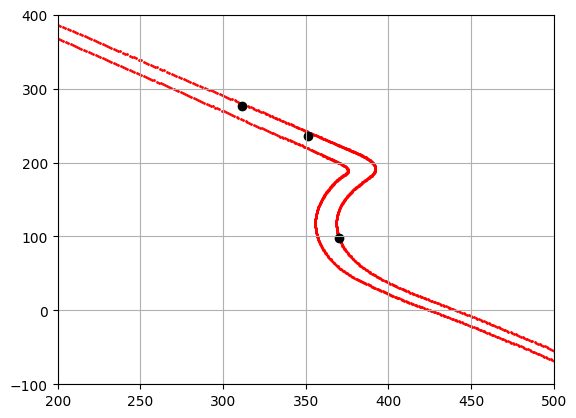

In [50]:
plt.scatter(left["WORLDPOSX"], left["WORLDPOSY"],s=1,c='red')
plt.scatter(right["WORLDPOSX"], right["WORLDPOSY"], s=1,c='red')
plt.scatter(nearest_neighbors_data["BEFORE_ENTRY_BRAKE_X"][0], nearest_neighbors_data["BEFORE_ENTRY_BRAKE_Y"][0], c='black')
plt.scatter(nearest_neighbors_data["WITHIN_BRAKE_X"][0], nearest_neighbors_data["WITHIN_BRAKE_Y"][0], c='black')
plt.scatter(nearest_neighbors_data["WITHIN_THROTTLE_X"][0], nearest_neighbors_data["WITHIN_THROTTLE_Y"][0], c='black')
plt.xlim(200, 500)
plt.ylim(-100, 400)
plt.grid()
plt.show()

# Estimating our final speed based on our data

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
# Create a new DataFrame to store the rows that satisfy the condition
final_df = pd.DataFrame(columns=df_agg_total.columns)

# If X, Y = 0 for each of the 3 we can
for index, row in df_agg_total.iterrows():
  if (row["BEFORE_ENTRY_BRAKE_X"] == row["BEFORE_ENTRY_BRAKE_Y"] == row["WITHIN_BRAKE_X"] == row["WITHIN_BRAKE_Y"] == row["WITHIN_THROTTLE_X"] == row["WITHIN_THROTTLE_Y"] == 0):
    continue
  else:
    final_df = final_df.append(row)


In [53]:
final_df["noise"] = np.random.normal(0, 1, len(final_df))
final_df

,CURRENT_LAP_TIME_MS,SPEED_KPH,BEFORE_ENTRY_BRAKE_X,BEFORE_ENTRY_BRAKE_Y,BEFORE_ENTRY_BRAKE_GEAR,BEFORE_ENTRY_BRAKE_STEERING,BEFORE_ENTRY_BRAKE_SPEED,BEFORE_ENTRY_BRAKE_RPM,WITHIN_BRAKE_X,WITHIN_BRAKE_Y,WTHIN_BRAKE_GEAR,WITHIN_BRAKE_STEERING,WITHIN_BRAKE_SPEED,WITHIN_BRAKE_RPM,WITHIN_THROTTLE_X,WITHIN_THROTTLE_Y,WITHIN_THROTTLE_GEAR,WITHIN_THROTTLE_STEERING,WITHIN_THROTTLE_SPEED,WITHIN_THROTTLE_RPM,noise
1.00346768666644e+19_1,9292.0,264.0,317.043945,270.647095,8.0,0.004349,314.0,10905.0,351.356781,236.377853,0.0,0.083635,225.0,9577.0,368.082977,98.278923,4.0,-0.140398,172.0,10706.0,0.461090
1.00346768666644e+19_2,9309.0,264.0,310.493561,277.280243,8.0,0.006088,322.0,11187.0,350.288940,238.674042,0.0,0.171527,241.0,9337.0,367.813263,98.085762,4.0,-0.099107,164.0,10314.0,-0.428884
1.0045550089308109e+19_1,6890.0,257.0,326.941986,261.094025,8.0,-0.008652,278.0,9431.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,369.129425,94.604286,4.0,-0.121080,188.0,11872.0,1.010317
1.0045550089308109e+19_2,5764.0,206.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,367.765686,98.796402,5.0,-0.141405,195.0,10702.0,0.617151
1.0045550089308109e+19_3,8175.0,262.0,311.309509,276.671387,8.0,-0.006088,293.0,9950.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,378.584595,63.873695,5.0,-0.179675,208.0,11371.0,-0.236514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.93719767677717e+18_2,8759.0,271.0,320.462250,267.711731,8.0,0.002518,290.0,9877.0,352.396942,236.498169,0.0,0.112932,231.0,10356.0,367.964752,98.145020,5.0,-0.156329,206.0,11225.0,0.226420
9.93719767677717e+18_3,8693.0,271.0,327.554535,261.473999,8.0,0.009018,286.0,9729.0,352.182373,236.721283,0.0,0.093980,232.0,10379.0,368.967682,99.096771,5.0,-0.174456,204.0,11190.0,-0.500917
9.943356580072892e+18_1,8674.0,274.0,314.986145,273.048645,8.0,0.003891,309.0,10545.0,351.546967,237.041397,0.0,0.087022,216.0,9617.0,368.035370,99.284180,5.0,-0.153491,211.0,11483.0,-0.394248
9.943356580072892e+18_2,8640.0,273.0,315.281097,272.392517,8.0,0.001144,305.0,10413.0,351.086670,237.644592,0.0,0.091966,231.0,10316.0,365.998932,97.524109,5.0,-0.219226,209.0,11471.0,-0.711881


In [55]:
## Random Forest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 225.96935740740741
